In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from datetime import datetime
import ta
# import tensorflow.compat.v1.keras.layers.CuDNNLSTM as CuDNNLSTM

In [45]:
import tensorflow as tf

# Set TensorFlow to only allocate memory on the GPU when needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [46]:
# Load the Bitcoin price data
bitcoin_data = pd.read_csv(r'C:\Users\MrBios\Documents\Development\IA-BTC-2023\csv\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

# Drop missing values
bitcoin_data.dropna(inplace=True)


In [47]:
# Keep the necessary columns
bitcoin_data = bitcoin_data[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)']]
bitcoin_data = bitcoin_data.tail(50000)

In [48]:
# Convert Timestamp to datetime format
bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'], unit='s')


In [49]:
# Compute RSI
bitcoin_data['RSI'] = ta.momentum.rsi(close=bitcoin_data["Close"], fillna=True)

# Compute MACD
bitcoin_data['MACD'] = ta.trend.macd(close=bitcoin_data["Close"], fillna=True)
bitcoin_data['MACD_signal'] = ta.trend.macd_signal(close=bitcoin_data["Close"], fillna=True)
bitcoin_data['MACD_diff'] = ta.trend.macd_diff(close=bitcoin_data["Close"], fillna=True)


In [50]:
# Prepare the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff']])


In [51]:
timeframe = 60
X = []
y = []
for i in range(timeframe, len(scaled_data) - 10):
    X.append(scaled_data[i - timeframe:i, :])
    y.append(scaled_data[i:i + 10, 3])  # Predicting the 'Close' column
X = np.array(X)
y = np.array(y)

In [52]:
X.shape, y.shape

((49930, 60, 10), (49930, 10))

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# save train and test variables
np.save('V5/X_train.npy', X_train)
np.save('V5/X_test.npy', X_test)
np.save('V5/y_train.npy', y_train)
np.save('V5/y_test.npy', y_test)
# save scaler
np.save('V5/scalerv5.npy', scaler)

In [55]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1]))

In [75]:
y_train.shape[1]

10

In [56]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
625/625 [==============================] - 10s 13ms/step - loss: 0.0118 - val_loss: 2.2183e-04
Epoch 2/50
625/625 [==============================] - 8s 12ms/step - loss: 0.0029 - val_loss: 2.8968e-04
Epoch 3/50
625/625 [==============================] - 7s 12ms/step - loss: 0.0018 - val_loss: 1.4530e-04
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 0.0013 - val_loss: 1.8136e-04
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 9.4005e-04 - val_loss: 3.8136e-04
Epoch 6/50
625/625 [==============================] - 7s 12ms/step - loss: 7.4018e-04 - val_loss: 1.8700e-04
Epoch 7/50
625/625 [==============================] - 8s 12ms/step - loss: 6.3327e-04 - val_loss: 1.2989e-04
Epoch 8/50
625/625 [==============================] - 8s 12ms/step - loss: 5.6563e-04 - val_loss: 1.0923e-04
Epoch 9/50
625/625 [==============================] - 8s 12ms/step - loss: 5.4839e-04 - val_loss: 1.8486e-04
Epoch 10/50
625/625 [=============

In [58]:
# Save the model and weights
version = "V5"
now = datetime.now()
format_date = now.strftime("%Y-%m-%d-%H-%M")
model.save(f'{version}/models/2-{version}-model_{format_date}.h5')
model.save_weights(f'{version}/models/2-{version}-weights_{format_date}.h5')

In [59]:
# Make predictions
predictions = model.predict(X_test)

313/313 [==============================] - 2s 4ms/step


In [60]:
# Scale the predictions back to original values
predictions = scaler.inverse_transform(predictions)
# Scale the predictions back to original values
# Reshape the predictions to match the expected shape of (1982, 30)

In [61]:
# predict the rsi and macd
rsi_predictions = predictions[:, 6]
macd_predictions = predictions[:, 7]
print(rsi_predictions)
print(macd_predictions)



[68.057236 95.600426 92.38623  ... 40.596134 77.89692  63.26933 ]
[ 148.58554  405.6313   375.63974 ... -107.75773  240.42046  103.88611]


In [62]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 1812011.4319051856


In [63]:
# Scale the predictions back to original values
predictions = scaler.inverse_transform(predictions)
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 17061751496364.496


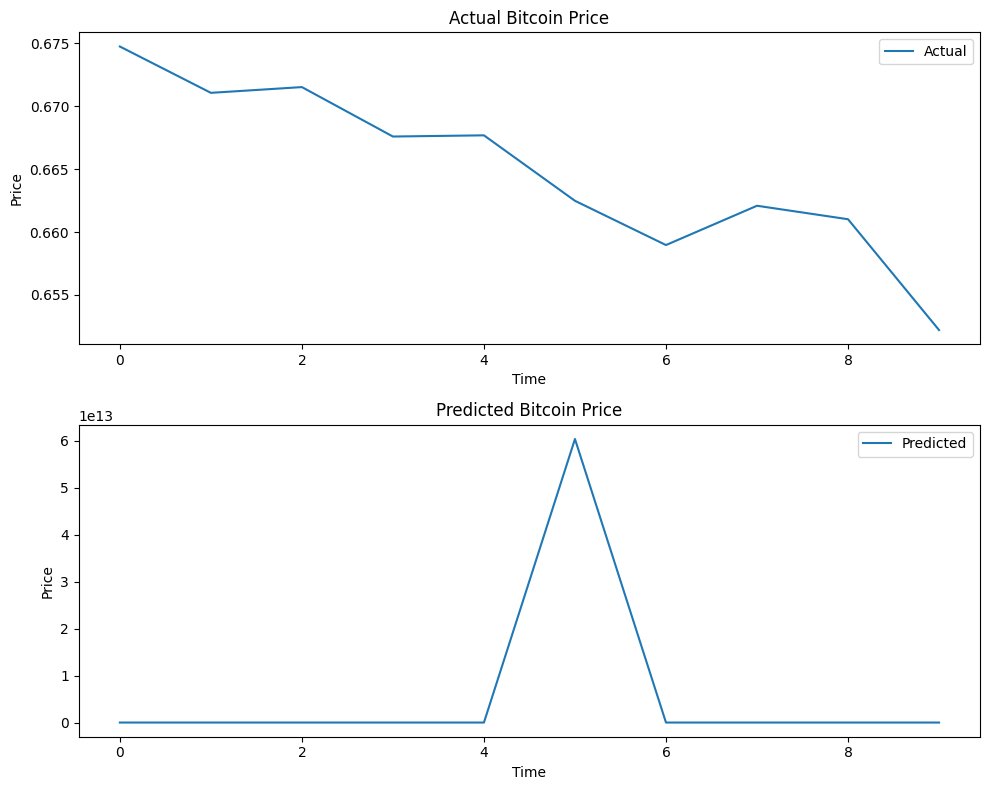

In [64]:
# Plot the actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(y_test[0], label='Actual')
ax1.set_title('Actual Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

ax2.plot(predictions[0], label='Predicted')
ax2.set_title('Predicted Bitcoin Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

plt.tight_layout()
plt.show()

In [65]:
import yfinance as yf
from datetime import datetime
import numpy as np
from datetime import datetime, timedelta
import ccxt

In [66]:
timeframe = '1m'
symbol = 'BTC/USDT'
minutes = 60 
since = datetime.now() - timedelta(minutes=minutes)
since = int(since.timestamp() * 1000)
limit = minutes+1
show_more_graph = False

In [67]:
# downloade the data with yfinance, get the last 2 hours
# last_60_minutes = yf.download(tickers='BTC-USD', period='7d', interval='1m')
# use ccxt to get the last 2 hours
exchange = ccxt.binance()
last_60_minutes = exchange.fetch_ohlcv('BTC/USDT', timeframe=timeframe, since=since, limit=limit)
last_60_minutes = pd.DataFrame(last_60_minutes, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
last_60_minutes['Timestamp'] = pd.to_datetime(last_60_minutes['Timestamp'], unit='ms')
last_60_minutes.set_index('Timestamp', inplace=True)
last_60_minutes.index = last_60_minutes.index + pd.DateOffset(hours=2)
last_60_minutes.tail(1)

,Open,High,Low,Close,Volume
Timestamp,,,,,
2023-06-20 09:33:00,26817.73,26822.83,26817.72,26822.82,8.84882


In [68]:

# 2. Scale the data to be values between 0 and 1
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[["Close"]])
# 3. Reshape the data into the shape accepted by the LSTM model
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], 1)) # cannot reshape array of size 60 into shape (1,1,1)
# 4. Make predictions using the LSTM model
pred = model.predict(last_60_minutes_scaled)
pred = scaler.inverse_transform(pred)

1/1 [==============================] - 0s 399ms/step


In [69]:
# Create two separate subplots for actual and predicted values
if show_more_graph :
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Plot the actual values
    ax1.plot(last_60_minutes.index[-minutes:], last_60_minutes["Close"].tail(minutes), label='Actual')
    ax1.set_title('Actual Bitcoin Price')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.legend()

    # Plot the predicted values
    pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0][:30]))
    ax2.plot(pred_time, pred_values, label='Predicted')
    ax2.set_title('Predicted Bitcoin Price')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax2.legend()

    # Format the tick labels to display numbers in regular format
    ax1.get_yaxis().get_major_formatter().set_useOffset(False)
    ax2.get_yaxis().get_major_formatter().set_useOffset(False)

    # Display the plot
    plt.tight_layout()
    plt.show()


In [70]:
pred.mean()
pred_time = pd.date_range(start=last_60_minutes.index[-1], periods=len(pred[0]) + 1, freq='1min')

In [71]:
# at what time will the price be at the predicted price
print("The Bitcoin price will be at {} at {}.".format(pred[0][-1], pred_time[-1]))
# add a what time the prediction started
print("The prediction started at {}.".format(pred_time[0]))
print("The Bitcoin price was at {} at {}.".format(last_60_minutes["Close"].iloc[-1], last_60_minutes.index[-1]))

The Bitcoin price will be at 26766.41015625 at 2023-06-20 09:43:00.
The prediction started at 2023-06-20 09:33:00.
The Bitcoin price was at 26822.82 at 2023-06-20 09:33:00.


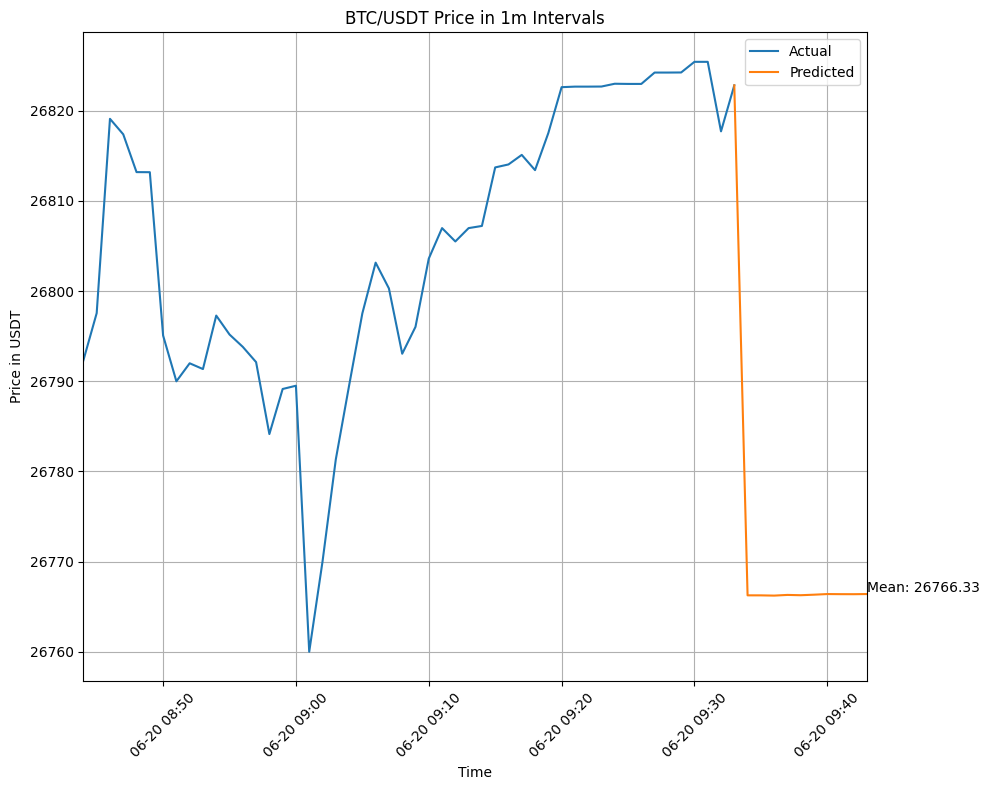

In [74]:
import matplotlib.dates as mdates

# Create a single subplot for both actual and predicted values
fig, ax = plt.subplots(figsize=(10, 8))

last_amount_of_points = -50
# Plot the actual values for the last 100 data points
ax.plot(last_60_minutes.index[last_amount_of_points:], last_60_minutes["Close"].tail(last_amount_of_points * -1), label='Actual')
ax.grid(True)
ax.set_title(f'{symbol} Price in {timeframe} Intervals')
ax.set_xlabel('Time')
pair = symbol.split('/')
ax.set_ylabel('Price in ' + pair[1])

# Plot all the predicted values
pred_time = pd.date_range(start=last_60_minutes.index[-1], periods=len(pred[0]) + 1, freq='1min')
pred_values = np.concatenate(([last_60_minutes["Close"].iloc[-1]], pred[0]))
ax.plot(pred_time, pred_values, label='Predicted')

# Format the tick labels to display numbers in regular format
ax.get_yaxis().get_major_formatter().set_useOffset(False)

# Set the x-axis limits to show both actual and predicted values
ax.set_xlim(last_60_minutes.index[last_amount_of_points], pred_time[-1])

# Format the tick labels with additional minutes information
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%M'))
# Rotate the x-axis tick labels
ax.xaxis.set_tick_params(rotation=45)

# Display the mean value of pred
mean_pred = pred.mean()
ax.text(pred_time[-1], mean_pred, f"Mean: {mean_pred:.2f}", verticalalignment='bottom')

# Display the legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
